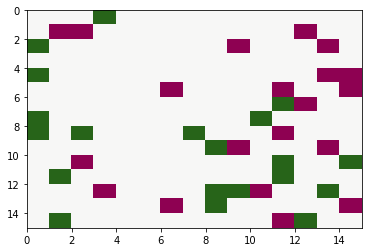

In [65]:
#Oppgave 1 a) og b)
import numpy as np
import matplotlib.pyplot as plt

def generate_grid_of_monomers(N,M):
    grid = np.zeros((N,N)) #lager et grid av riktig størrelse fylt av nuller
    for i in range(M):
        randomPosition = (np.random.randint(N),np.random.randint(N)) #velger tilfeldig koordinat
        while grid[randomPosition] != 0:  #hvis koordinatet ikke er opptatt setter vi en positiv monomer der, til vi har M stk
            randomPosition = (np.random.randint(N),np.random.randint(N))
        grid[randomPosition] = i+1
    for i in range(M):
        randomPosition = (np.random.randint(N),np.random.randint(N)) #så det samme for negative monomerer
        while grid[randomPosition] != 0:
            randomPosition = (np.random.randint(N),np.random.randint(N))
        grid[randomPosition] = -(i+1)
    return grid
    

def visualize_grid(grid, cmap='PiYG', low_val = -1, high_val = 1): #viser by default kun farger for verdier mellom -1 og 1
    plt.pcolormesh(grid,cmap=cmap, vmin = low_val, vmax = high_val)
    plt.gca().invert_yaxis() #plotter i matrisekoordinater

N, M = 15, 20
Example_system = generate_grid_of_monomers(N,M)
visualize_grid(Example_system)

In [36]:
def get_neighbors_coordinates(N, i, j):
    neighborarray = [[i, (j-1)%N],
                     [i, (j+1)%N],
                     [(i-1)%N, j],
                     [(i+1)%N, j]]
    return neighborarray

def get_neighboring_monomers(grid, N, i, j):
    neighborarray = get_neighbors_coordinates(N, i, j)
    for neighbor in neighborarray:
        if grid[neighbor[0],neighbor[1]]==0:
            neighborarray.remove(neighbor)
    return neighborarray
print(get_neighboring_monomers(Example_system, N, 8, 11))

[[8, 10], [8, 12], [7, 11]]


In [48]:
alpha_1 = ((1.6022E-19)**2)/(4*np.pi*(8.8542E-12)*78*(23E-6)**2)

def energy_calculation(grid, N, alpha = alpha_1): #grid er gridet som blir generert gjennom monomer_grid
    energy = 0
    monomers = np.argwhere(grid != 0)
    for monomer in monomers:
        i,j = monomer[0], monomer[1]
        for neighbor in get_neighboring_monomers(grid, N, i, j):
            sign = grid[neighbor[0], neighbor[1]]*grid[i, j]
            if sign < 0:
                sign = -1
            elif sign > 0:
                sign = 1
            energy += sign #summerer opp monomer energy
            #returnerer E/alpha dvs antall interaksjoner mellom monomerer (negativ for forskjellig fortegn)
    return energy*alpha/2 #deler på 2 fordi vi itererer over alle monomerer og det er 2 monomerer i enhver interaksjon

print(energy_calculation(Example_system, N))

3.3548664673968075e-20


In [49]:
# We use the convention for directions: 0 = left, 1= right, 2=up, 3=down
# If we try to move monomers on top of a different monomer, nothing happens (This is an illegal move)
def move_monomer(grid, monomer_value, direction, N):
    # First we need to find the coordinates of the monomer we want to move
    # np.argwhere returns an array of all the coordinates that fulfill grid==monomer_value
    # Because there is only one grid point fulfilling grid==monomer_value, we extract the first element
    monomer_coordinates = np.argwhere(grid==monomer_value)[0] 

    # Now we find the coordiates of the neighboring grid point in the desired direction (using function from 1c)
    array_of_all_neighbor_coordinates = get_neighbors_coordinates(N=N, i=monomer_coordinates[0],
                                                                 j=monomer_coordinates[1])
    desired_neigbor_coordinate = array_of_all_neighbor_coordinates[direction]
    
    # Now we check if there is solvent (i.e. a zero) at the desired coordinate
    # meaning that we can move our monomer
    if grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]]==0:
        grid[desired_neigbor_coordinate[0], desired_neigbor_coordinate[1]] = monomer_value # moving the monomer
        grid[monomer_coordinates[0], monomer_coordinates[1]] = 0 #replacing old position of the monomer with solvent
    return grid

In [50]:


def monte_carlo_sim(N_s, N, M, T, grid,alpha = alpha_1):
    beta = 1/(T*1.380649E-23) #1/(kB*T)
    epsilon = np.zeros(N_s)
    for i in range(N_s):
        E = energy_calculation(grid, N)
        #Generates a random integer between 0 and 3 (low is inclusive, high is not)
        random_direction = np.random.randint(low=0, high=4) 
        # For generating a random monomer value, we generate the magntitude and sign seperately.
        magnitude = np.random.randint(1, M + 1)
        sign = 2 * np.random.randint(0, 2) - 1 # Easy way to generate random sign
        new_grid=np.copy(grid)
        new_grid = move_monomer(new_grid, sign*magnitude, random_direction, N) # This function already avoids illegal moves
        E_new = energy_calculation(new_grid, N)
        if E_new < E:
            grid = new_grid
            E = E_new
        elif np.random.random()<np.exp(-beta*(E_new-E)):
            grid = new_grid
            E = E_new
        else:
            pass
        epsilon[i] = E/alpha
    return epsilon, grid

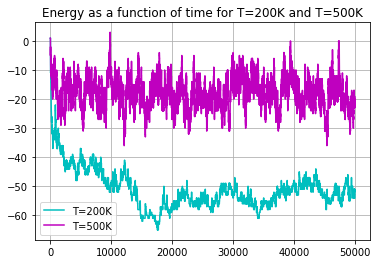

't_equil is smaller for higher teperatures as the likelihood of monomers moving away from local minima is larger,\ni.e. monomers move more frequently and also settle in a equilibrium faster, but this equilibrium has a higher potential energy\nthan the low temperature variant because the temperature (by definition) increases the energy of the system. In the high T \nsimulation the monomers move more easily away from "bonds" with other monomers, this is the reason for the higher potential \nenergy. For the lower temperature simulation this takes more moves to accomplish, as the probability of the low \ntemperature grid being in a local equilibrium is larger than for the high temperature grid.'

In [51]:
N,M = 15, 25
N_s=50000
grid=generate_grid_of_monomers(N,M)
T_1=200
T_2=500
timesteps = np.arange(N_s)
low_T_energy, low_T_grid = monte_carlo_sim(N_s, N, M, T_1, grid)
np.savez('lowTsimulation.npz', low_T_grid=low_T_grid)

high_T_energy, high_T_grid = monte_carlo_sim(N_s, N, M, T_2, grid)

plt.figure(figsize=(10,8))
plt.title('Energy as a function of time for T=200K and T=500K')
plt.plot(timesteps, low_T_energy, 'c')
plt.plot(timesteps, high_T_energy, 'm')
plt.legend(['T=200K','T=500K'])
plt.grid(True)
plt.xlabel('Timesteps N_s')
plt.ylabel('Energy E/α')
plt.show()

'''t_equil is smaller for higher teperatures as the likelihood of monomers moving away from local minima is larger,
i.e. monomers move more frequently and also settle in a equilibrium faster, but this equilibrium has a higher potential energy
than the low temperature variant because the temperature (by definition) increases the energy of the system. In the high T 
simulation the monomers move more easily away from "bonds" with other monomers, this is the reason for the higher potential 
energy. For the lower temperature simulation this takes more moves to accomplish, as the probability of the low 
temperature grid being in a local equilibrium is larger than for the high temperature grid.'''

'''We find that timesteps needed to reach equilibrium is at approximately 2500 steps for T=500K and at approx 20000 steps
for T=200K.'''

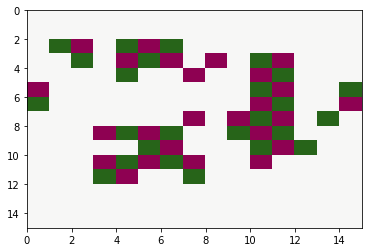

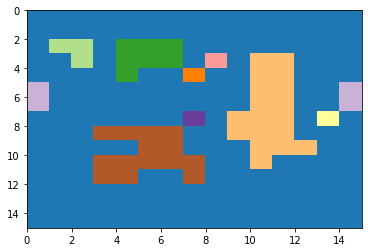

In [119]:
#Oppgave 1 g)
def generate_cluster_grid(grid, M):
    largest_possible_cluster_value = 2*M
    cluster_number = largest_possible_cluster_value + 1
    #nummererer cluster og gir hvert cluster et nummer som garantert er høyere enn hvis alle monomerer er adskilt
    for monomer in np.argwhere(grid!=0): #finner koordinater til punkter i grid som ikke er lik 0
        i,j = monomer[0],monomer[1]
        grid[i][j] = cluster_number #lager nytt cluster
        cluster_number += 1
        nearest_neighbors = get_neighboring_monomers(grid, N, i, j)
        for neighbor in nearest_neighbors:
            if(abs(grid[neighbor[0]][neighbor[1]])<abs(grid[i][j])):
                if (grid[neighbor[0]][neighbor[1]]>=largest_possible_cluster_value):
                #hvis naboen er del av et cluster allerede får monomeren naboens verdi
                    for cluster_item in np.argwhere(grid == grid[i][j]):
                    #for alle monomerer i andre cluster som monomeren er en del av
                        grid[cluster_item[0],cluster_item[1]] = grid[neighbor[0]][neighbor[1]]
                    cluster_number -= 1
            else:
                for cluster_item in np.argwhere(grid == grid[neighbor[0]][neighbor[1]]):
                    #for alle monomerer i andre cluster som naboen er en del av
                        grid[cluster_item[0],cluster_item[1]] = grid[i][j]
                    
                '''merger cluster ved å gi alle monomerer i clusteret med høyest verdi verdien til det clusteret
                som er "eldst", dvs. lavest cluster verdi over 2, hvis ikke naboen er del av et eksisterende cluster,
                legger vi til naboen i monomerens cluster'''
    for monomer in np.argwhere(grid!=0): #finner koordinater til punkter i grid som ikke er lik 0
        i,j = monomer[0],monomer[1]
        grid[i][j] -= largest_possible_cluster_value #gir clusterne lavest mulig verdi
    return grid


lowTgrid = np.load('lowTsimulation.npz')['low_T_grid']
visualize_grid(lowTgrid)
plt.show()
visualize_grid(generate_cluster_grid(lowTgrid, M), cmap = 'Paired', high_val = None)

In [120]:
def mean_cluster_size(cluster_grid, M):
    amount_of_clusters = 1
    for row in cluster_grid:
        biggest_in_row = max(row)
        if biggest_in_row > amount_of_clusters:
            amount_of_clusters = biggest_in_row
    return 2*M/amount_of_clusters

In [ ]:
#Oppgave 2 a)
def generate_grid_of_polymers(N,M,L):
    